# Práctica 7: Redes Neuronales (Autoencoders Variacionales)

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones.

La entrega de la práctica será en la siguiente sesión a menos que la indicación sea otra. La revisión iniciará al iniciar la sesión y únicamente podrá ser evaluada durante la duración de la sesión.

__Para esta práctica se deben usar bibliotecas__. Se recomienda el uso de:

- scikit-learn (https://scikit-learn.org/stable/)
- plotly express (https://plotly.com/python/plotly-express/)
- torch (https://pytorch.org/).

## Asignación 1

Seleccione algun dataset de su preferencia para el cual sea viable entrenar un modelo generativo (VAE), preferentemente de imagenes (pequeñas). Particione sus datos para poder realizar selección de modelos (__conjunto de validación__).

In [1]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [2]:
pip install opencv-python

                                              0.0/38.2 MB ? eta -:--:--
                                              0.1/38.2 MB 1.7 MB/s eta 0:00:24
                                              0.2/38.2 MB 2.9 MB/s eta 0:00:14
                                              0.7/38.2 MB 4.7 MB/s eta 0:00:09
     -                                        1.7/38.2 MB 8.9 MB/s eta 0:00:05
     ---                                      3.1/38.2 MB 14.1 MB/s eta 0:00:03
     -----                                    4.9/38.2 MB 18.6 MB/s eta 0:00:02
     -------                                  6.9/38.2 MB 21.9 MB/s eta 0:00:02
     ---------                                8.9/38.2 MB 23.6 MB/s eta 0:00:02
     -----------                             10.9/38.2 MB 38.5 MB/s eta 0:00:01
     -------------                           12.8/38.2 MB 43.5 MB/s eta 0:00:01
     --------------                          14.1/38.2 MB 43.7 MB/s eta 0:00:01
     --------------                          14.1/38

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten,Reshape
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss


In [6]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Función para cargar el dataset
def load_dataset(dataset_path):
    images = []
    for filename in os.listdir(dataset_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(dataset_path, filename)
            image = Image.open(image_path).convert('L')  # Convertir a escala de grises
            image = image.resize((64, 64))  # Redimensionar la imagen
            image = np.array(image) / 255.0  # Convertir a numpy y normalizar
            images.append(image)
    return np.array(images)

# Cargar y dividir el dataset
dataset_path = "C:/Users/viane/Music/ESCOM/Modelado predictivo/Primer parcial/Practica 7/all-dogs"
images = load_dataset(dataset_path)

# Las imágenes deben tener una dimensión extra para el canal de color (gris en este caso)
# En PyTorch, la dimensión del canal va al principio
images = images.reshape(-1, 1, 64, 64)

# Dividir en entrenamiento y validación
train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

# Convierte las imágenes de numpy arrays a torch tensors
train_images = torch.from_numpy(train_images).float()
val_images = torch.from_numpy(val_images).float()

# Crea TensorDatasets
train_dataset = TensorDataset(train_images, train_images)  # La entrada es la misma que la salida para un autoencoder
val_dataset = TensorDataset(val_images, val_images)

# Crea DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)


## Asignación 2

Realice un análisis exploratorio de datos y el preprocesamiento necesario para el dataset seleccionado.

Tamaño del dataset de entrenamiento: 16463
Tamaño del dataset de validación: 4116
Forma de las imágenes en el dataset: torch.Size([1, 64, 64])
Número de canales de color: 1


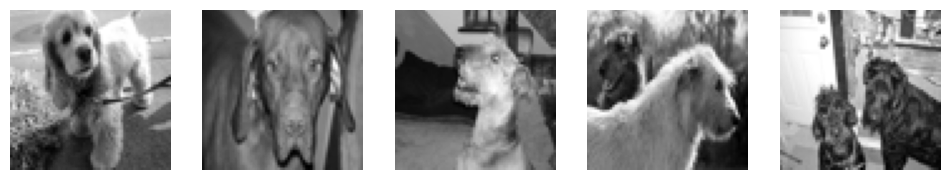

Estadísticas descriptivas del dataset de entrenamiento:
Media: tensor(0.4518)
Desviación estándar: tensor(0.2426)
Valor mínimo: tensor(0.)
Valor máximo: tensor(1.)


In [7]:
import matplotlib.pyplot as plt

# Información básica del dataset
print("Tamaño del dataset de entrenamiento:", len(train_dataset))
print("Tamaño del dataset de validación:", len(val_dataset))
print("Forma de las imágenes en el dataset:", train_images.shape[1:])
print("Número de canales de color:", train_images.shape[1])

# Visualización de algunas imágenes
n_samples = 5
random_indices = np.random.choice(len(train_dataset), size=n_samples, replace=False)
fig, axes = plt.subplots(1, n_samples, figsize=(12, 4))
for i, index in enumerate(random_indices):
    image, _ = train_dataset[index]
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()

# Estadísticas descriptivas
print("Estadísticas descriptivas del dataset de entrenamiento:")
print("Media:", train_images.mean())
print("Desviación estándar:", train_images.std())
print("Valor mínimo:", train_images.min())
print("Valor máximo:", train_images.max())


## Asignación 3

Ajuste un Autoencoder Variacional (VAE) que permita realizar la generación de nuevos datos. Debe generar las curvas de entrenamiento (y graficarlas) e implementar el método de early stopping para seleccionar el modelo más adecuado.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [9]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Latent space
        self.fc_mu = nn.Linear(32 * 16 * 16, latent_dim)
        self.fc_logvar = nn.Linear(32 * 16 * 16, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * 16 * 16),
            nn.Unflatten(1, (32, 16, 16)),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar


In [10]:
latent_dim = 32
vae = VAE(latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(vae.parameters(), lr=0.0001)


In [11]:
def train_vae(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    patience = 10
    early_stopping_counter = 0

    model.to(device)

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        # Training
        model.train()
        for images, _ in train_loader:
            images = images.to(device)

            optimizer.zero_grad()

            reconstructed, mu, logvar = model(images)
            loss = criterion(reconstructed, images)

            # Kullback-Leibler (KL) divergence regularization term
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss += kl_loss

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        # Validation
        model.eval()
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)

                reconstructed, mu, logvar = model(images)
                loss = criterion(reconstructed, images)

                # Kullback-Leibler (KL) divergence regularization term
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss += kl_loss

                val_loss += loss.item() * images.size(0)

        # Calculate average losses
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses


Epoch 1/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 2/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 3/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 4/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 5/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 6/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 7/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 8/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 9/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 10/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 11/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 12/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 13/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 14/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 15/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 16/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 17/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 18/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 19/300: Train Loss: 0.0588, Val Loss: 0.0588
Epoch 20/300: Train Loss: 0.0588, Val Lo

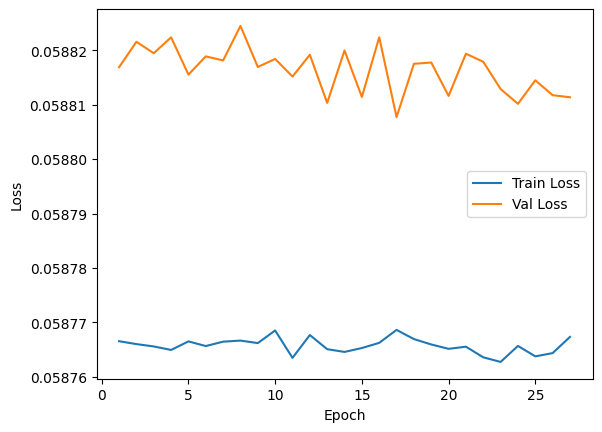

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 300
train_losses, val_losses = train_vae(vae, train_loader, val_loader, criterion, optimizer, num_epochs, device)

# Plot training curves
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Asignación 4

Realice la generación de nuevos datos utilizando su modelo. Debe generar evidencia sobre el correcto funcionamiento de su modelo.

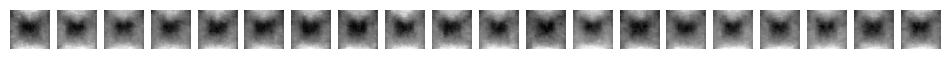

In [14]:
# Generar nuevas imágenes a partir del espacio latente
num_samples = 20
latent_samples = torch.randn(num_samples, latent_dim).to(device)
generated_images = vae.decoder(latent_samples).cpu().detach()

# Visualizar las imágenes generadas
fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))
for i in range(num_samples):
    axes[i].imshow(generated_images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()


In [17]:
torch.save(vae.state_dict(), "modelo_vae.pt")


In [18]:
vae = VAE(latent_dim)
vae.load_state_dict(torch.load("modelo_vae.pt"))


<All keys matched successfully>